In [1]:
import pandas as pd
from mordred import Calculator, descriptors
from rdkit import Chem,DataStructs
from rdkit.Chem import AllChem,PandasTools
import rdkit
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, balanced_accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV, train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from rdkit.Chem import rdFingerprintGenerator

In [2]:
df=pd.read_csv(r"C:\Users\19189\Desktop\original_data.csv")
df.head(2)

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50
0,68523-18-2,460.0,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758
1,88-04-0,3830.0,CC1C=C(O)C=C(C)C=1Cl,3.583199


In [3]:
def MACCSfp(mol):
    fp = rdkit.Chem.rdMolDescriptors.GetMACCSKeysFingerprint(mol)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [4]:
PandasTools.AddMoleculeColumnToFrame(df,'Canonical_QSARr','Molecule')
df.head(2)

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50,Molecule
0,68523-18-2,460.0,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758,<rdkit.Chem.rdchem.Mol object at 0x000001B1B7B...
1,88-04-0,3830.0,CC1C=C(O)C=C(C)C=1Cl,3.583199,<rdkit.Chem.rdchem.Mol object at 0x000001B1B7B...


In [5]:
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048)
mfp_list = []
for mol in df['Molecule']:
  mfp = mfpgen.GetFingerprintAsNumPy(mol)
  mfp_list.append(mfp)

In [6]:
df["MACCS_FPs"] = df.Molecule.apply(MACCSfp)
df.head(2)

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50,Molecule,MACCS_FPs
0,68523-18-2,460.0,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758,<rdkit.Chem.rdchem.Mol object at 0x000001B1B7B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,88-04-0,3830.0,CC1C=C(O)C=C(C)C=1Cl,3.583199,<rdkit.Chem.rdchem.Mol object at 0x000001B1B7B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
df["Morgan_FPs"] = mfp_list
df.head(2)

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50,Molecule,MACCS_FPs,Morgan_FPs
0,68523-18-2,460.0,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758,<rdkit.Chem.rdchem.Mol object at 0x000001B1B7B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,88-04-0,3830.0,CC1C=C(O)C=C(C)C=1Cl,3.583199,<rdkit.Chem.rdchem.Mol object at 0x000001B1B7B...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
MACCS_fp_df = df["MACCS_FPs"].apply(pd.Series)
MACCS_fp_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1,1,1,0


In [9]:
MACCS_x = MACCS_fp_df.iloc[:,0:167]
y = df['LogLD50']

In [10]:
Morgan2_fp_df = df["Morgan_FPs"].apply(pd.Series)
Morgan2_fp_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
Morgan2_fp_df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11982,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11985,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
Morgan2_x = Morgan2_fp_df.iloc[:,0:2048]

In [13]:
MD=pd.read_csv(r"C:\Users\19189\Desktop\mordred_descriptors.csv")
MD.head(2)

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,68523-18-2,460.0,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758,0.0,0.0,0,0,34.992970,2.613976,...,10.344674,84.588084,416.069448,9.044988,2244,39,146.0,172.0,10.201389,6.166667
1,88-04-0,3830.0,CC1C=C(O)C=C(C)C=1Cl,3.583199,0.0,0.0,0,0,11.643052,2.307250,...,9.078065,39.748909,156.034193,8.212326,110,13,48.0,54.0,4.944444,2.222222


In [14]:
MD_x=MD.iloc[:,4:1831]
MD_x =MD_x.astype(float)

In [25]:
MACCS_best_cat_params={
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS',
 'depth': 10,
 'iterations': 900,
 'l2_leaf_reg': 0.2557273602325932,
 'leaf_estimation_method': 'Gradient',
 'learning_rate': 0.0477685119153238,
 'random_strength': 0.0061100684626963,
 'rsm': 0.6847953796328295,
 'score_function': 'L2',
 'early_stopping_rounds':20,
 'eval_metric':'R2',
}

In [26]:
MACCS_best_xgb_params={'alpha': 0.0014906977558625,
 'booster': 'dart',
 'colsample_bytree': 0.8546173904005345,
 'eta': 0.0456833498124193,
 'gamma': 3.3542988420770624e-05,
 'grow_policy': 'depthwise',
 'lambda': 0.2943003047107695,
 'max_depth': 14,
 'min_child_weight': 10,
 'n_estimators': 220,
 'normalize_type': 'forest',
 'rate_drop': 0.024216902211587,
 'sample_type': 'weighted',
 'skip_drop': 0.001261004949685,
 'subsample': 0.7218018660663547,
 'random_state':42,
 'verbosity': 0,
 'objective': 'reg:squarederror'}

In [27]:
MD_best_xgb_params={'alpha': 5.965346832119681e-06,
 'booster': 'gbtree',
 'verbosity': 0,
 'tree_method': 'exact',
 'objective': 'reg:squarederror',
 'colsample_bytree': 0.7295911276220814,
 'gamma': 7.372146242868913e-08,
 'grow_policy': 'lossguide',
 'lambda': 0.0002210864159401,
 'max_depth': 9,
 'eta':0.05,
 'min_child_weight': 4,
 'n_estimators': 220,
 'normalize_type': None,
 'rate_drop':None,
 'sample_type':None,
 'skip_drop': None,
 'subsample': 0.926368451515968,
 'random_state':42}

In [36]:
MD_best_cat_params={'iterations': 1000, 
'learning_rate': 0.05195087349854926,
'depth': 10, 
'l2_leaf_reg': 0.8124329970418442,
'boosting_type': 'Ordered',
'bootstrap_type': 'MVS',
'random_strength': 0.00015070897262938095, 
'score_function': 'L2', 
'leaf_estimation_method':"Gradient",
'rsm': 0.3037411535337428,
'early_stopping_rounds':20,
'eval_metric':'R2'}

In [33]:
Morgan2_best_xgb_params={
 'alpha': 0.0332554199380306,
 'booster': 'dart',
 'colsample_bytree':0.3582744697233988,
 'gamma': 4.141460720575164e-08,
 'grow_policy': 'lossguide',
 'lambda': 2.433870694850693e-07,
 'max_depth': 15,
 'min_child_weight': 2,
 'n_estimators': 240,
 'normalize_type': 'tree',
 'rate_drop': 3.707365005799031e-05,
 'sample_type': 'weighted',
 'skip_drop': 0.070109299153102,
 'subsample': 0.937997400947438,
 'random_state':42,
 'verbosity': 0,
 'objective': 'reg:squarederror',
 'tree_method': "exact",
 'eta':0.0929003280025521}

In [34]:
Morgan2_best_cat_params={
 'boosting_type': 'Plain',
 'bootstrap_type': 'Bernoulli',
 'depth': 10,
 'iterations': 1200,
 'l2_leaf_reg': 0.2126401036375577,
 'leaf_estimation_method': 'Gradient',
 'learning_rate': 0.0783456753220752,
 'random_strength': 0.0065022422458716,
 'rsm': 0.7541723390342481,
 'score_function': 'Cosine',
 'subsample': 0.6926851907717733,
 'early_stopping_rounds':20,
 'eval_metric':'R2'}

In [37]:
from tqdm import tqdm
import catboost as cat
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
models = [cat.CatBoostRegressor(**MACCS_best_cat_params),
          xgb.XGBRegressor(**MACCS_best_xgb_params),
          cat.CatBoostRegressor(**Morgan2_best_cat_params),
          xgb.XGBRegressor(**Morgan2_best_xgb_params),
          cat.CatBoostRegressor(**MD_best_cat_params),
          xgb.XGBRegressor(**MD_best_xgb_params)]

model_names = ['C_MACCS', 'X_MACCS', 'C_Morgan2', 'X_Morgan2','C_MD', 'X_MD']
X=[MACCS_x,Morgan2_x,MD_x]
scores_df = pd.DataFrame()
y = df['LogLD50']
for idx, model in enumerate(models):
    scores = []
    id=int(idx/2)
    x=X[id]
    for train_index, test_index in tqdm(kfold.split(x, y)):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]  # Correct indexing using iloc
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]  # Correct indexing using iloc

        model = model
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        scores.append(r2)

    scores_df[str(model_names[idx])] = scores

0it [00:00, ?it/s]

0:	learn: 0.0321294	total: 308ms	remaining: 4m 37s
1:	learn: 0.0627333	total: 490ms	remaining: 3m 39s
2:	learn: 0.0914493	total: 729ms	remaining: 3m 37s
3:	learn: 0.1186472	total: 1.1s	remaining: 4m 7s
4:	learn: 0.1442115	total: 1.51s	remaining: 4m 29s
5:	learn: 0.1666325	total: 1.91s	remaining: 4m 44s
6:	learn: 0.1899921	total: 2.32s	remaining: 4m 55s
7:	learn: 0.2096294	total: 2.72s	remaining: 5m 3s
8:	learn: 0.2269182	total: 3.12s	remaining: 5m 8s
9:	learn: 0.2443100	total: 3.52s	remaining: 5m 13s
10:	learn: 0.2605239	total: 3.91s	remaining: 5m 16s
11:	learn: 0.2744587	total: 4.31s	remaining: 5m 18s
12:	learn: 0.2880642	total: 4.71s	remaining: 5m 21s
13:	learn: 0.3039792	total: 5.12s	remaining: 5m 23s
14:	learn: 0.3171009	total: 5.51s	remaining: 5m 24s
15:	learn: 0.3281297	total: 5.91s	remaining: 5m 26s
16:	learn: 0.3389698	total: 6.31s	remaining: 5m 27s
17:	learn: 0.3501094	total: 6.71s	remaining: 5m 28s
18:	learn: 0.3605291	total: 7.1s	remaining: 5m 29s
19:	learn: 0.3704199	total:

1it [06:02, 362.23s/it]

899:	learn: 0.9060630	total: 6m 1s	remaining: 0us
0:	learn: 0.0331264	total: 376ms	remaining: 5m 37s
1:	learn: 0.0646768	total: 777ms	remaining: 5m 49s
2:	learn: 0.0911688	total: 1.18s	remaining: 5m 52s
3:	learn: 0.1184097	total: 1.58s	remaining: 5m 55s
4:	learn: 0.1443208	total: 1.98s	remaining: 5m 54s
5:	learn: 0.1680931	total: 2.39s	remaining: 5m 55s
6:	learn: 0.1912011	total: 2.79s	remaining: 5m 56s
7:	learn: 0.2113416	total: 3.18s	remaining: 5m 54s
8:	learn: 0.2297683	total: 3.59s	remaining: 5m 55s
9:	learn: 0.2477400	total: 3.98s	remaining: 5m 54s
10:	learn: 0.2647758	total: 4.39s	remaining: 5m 54s
11:	learn: 0.2792661	total: 4.79s	remaining: 5m 54s
12:	learn: 0.2938614	total: 5.2s	remaining: 5m 54s
13:	learn: 0.3076109	total: 5.6s	remaining: 5m 54s
14:	learn: 0.3195364	total: 6.01s	remaining: 5m 54s
15:	learn: 0.3312688	total: 6.41s	remaining: 5m 54s
16:	learn: 0.3424173	total: 6.82s	remaining: 5m 54s
17:	learn: 0.3539976	total: 7.22s	remaining: 5m 54s
18:	learn: 0.3635551	total

2it [12:05, 363.00s/it]

899:	learn: 0.9083948	total: 6m 2s	remaining: 0us
0:	learn: 0.0356432	total: 365ms	remaining: 5m 28s
1:	learn: 0.0663852	total: 764ms	remaining: 5m 43s
2:	learn: 0.0962247	total: 1.16s	remaining: 5m 47s
3:	learn: 0.1228889	total: 1.55s	remaining: 5m 47s
4:	learn: 0.1475736	total: 1.95s	remaining: 5m 49s
5:	learn: 0.1681474	total: 2.36s	remaining: 5m 51s
6:	learn: 0.1883794	total: 2.77s	remaining: 5m 52s
7:	learn: 0.2077606	total: 3.17s	remaining: 5m 53s
8:	learn: 0.2263408	total: 3.57s	remaining: 5m 53s
9:	learn: 0.2436936	total: 3.97s	remaining: 5m 53s
10:	learn: 0.2594171	total: 4.37s	remaining: 5m 53s
11:	learn: 0.2751902	total: 4.77s	remaining: 5m 52s
12:	learn: 0.2915248	total: 5.18s	remaining: 5m 53s
13:	learn: 0.3041924	total: 5.58s	remaining: 5m 52s
14:	learn: 0.3172580	total: 5.98s	remaining: 5m 52s
15:	learn: 0.3312693	total: 6.38s	remaining: 5m 52s
16:	learn: 0.3435340	total: 6.78s	remaining: 5m 52s
17:	learn: 0.3556845	total: 7.19s	remaining: 5m 52s
18:	learn: 0.3664800	tot

3it [18:08, 362.98s/it]

899:	learn: 0.9050163	total: 6m 2s	remaining: 0us
0:	learn: 0.0331830	total: 369ms	remaining: 5m 31s
1:	learn: 0.0654089	total: 772ms	remaining: 5m 46s
2:	learn: 0.0951356	total: 1.16s	remaining: 5m 48s
3:	learn: 0.1195566	total: 1.56s	remaining: 5m 50s
4:	learn: 0.1467887	total: 1.97s	remaining: 5m 52s
5:	learn: 0.1680439	total: 2.37s	remaining: 5m 52s
6:	learn: 0.1901982	total: 2.77s	remaining: 5m 52s
7:	learn: 0.2101905	total: 3.17s	remaining: 5m 53s
8:	learn: 0.2295604	total: 3.57s	remaining: 5m 53s
9:	learn: 0.2479592	total: 3.97s	remaining: 5m 53s
10:	learn: 0.2626528	total: 4.38s	remaining: 5m 53s
11:	learn: 0.2778485	total: 4.78s	remaining: 5m 53s
12:	learn: 0.2923458	total: 5.18s	remaining: 5m 53s
13:	learn: 0.3086877	total: 5.59s	remaining: 5m 53s
14:	learn: 0.3228967	total: 5.98s	remaining: 5m 53s
15:	learn: 0.3336175	total: 6.37s	remaining: 5m 51s
16:	learn: 0.3443362	total: 6.76s	remaining: 5m 51s
17:	learn: 0.3540387	total: 7.17s	remaining: 5m 51s
18:	learn: 0.3636343	tot

4it [24:11, 362.88s/it]

899:	learn: 0.9008080	total: 6m 1s	remaining: 0us
0:	learn: 0.0326092	total: 361ms	remaining: 5m 24s
1:	learn: 0.0654064	total: 755ms	remaining: 5m 39s
2:	learn: 0.0940669	total: 1.14s	remaining: 5m 40s
3:	learn: 0.1186925	total: 1.53s	remaining: 5m 42s
4:	learn: 0.1440938	total: 1.91s	remaining: 5m 42s
5:	learn: 0.1663750	total: 2.31s	remaining: 5m 44s
6:	learn: 0.1857557	total: 2.7s	remaining: 5m 44s
7:	learn: 0.2078714	total: 3.09s	remaining: 5m 45s
8:	learn: 0.2283714	total: 3.49s	remaining: 5m 45s
9:	learn: 0.2456214	total: 3.88s	remaining: 5m 45s
10:	learn: 0.2608941	total: 4.28s	remaining: 5m 45s
11:	learn: 0.2760220	total: 4.67s	remaining: 5m 45s
12:	learn: 0.2896398	total: 5.07s	remaining: 5m 45s
13:	learn: 0.3029825	total: 5.47s	remaining: 5m 46s
14:	learn: 0.3150384	total: 5.87s	remaining: 5m 46s
15:	learn: 0.3278170	total: 6.27s	remaining: 5m 46s
16:	learn: 0.3394534	total: 6.67s	remaining: 5m 46s
17:	learn: 0.3501324	total: 7.06s	remaining: 5m 45s
18:	learn: 0.3586714	tota

5it [30:05, 361.13s/it]
5it [20:00, 240.06s/it]
0it [00:00, ?it/s]

0:	learn: 0.0419238	total: 83.2ms	remaining: 1m 39s
1:	learn: 0.0803015	total: 166ms	remaining: 1m 39s
2:	learn: 0.1128613	total: 247ms	remaining: 1m 38s
3:	learn: 0.1391964	total: 327ms	remaining: 1m 37s
4:	learn: 0.1632145	total: 410ms	remaining: 1m 37s
5:	learn: 0.1859643	total: 488ms	remaining: 1m 37s
6:	learn: 0.2061138	total: 572ms	remaining: 1m 37s
7:	learn: 0.2248319	total: 652ms	remaining: 1m 37s
8:	learn: 0.2406018	total: 738ms	remaining: 1m 37s
9:	learn: 0.2556830	total: 824ms	remaining: 1m 38s
10:	learn: 0.2678007	total: 908ms	remaining: 1m 38s
11:	learn: 0.2804517	total: 990ms	remaining: 1m 37s
12:	learn: 0.2906909	total: 1.07s	remaining: 1m 37s
13:	learn: 0.3012981	total: 1.15s	remaining: 1m 37s
14:	learn: 0.3112637	total: 1.23s	remaining: 1m 37s
15:	learn: 0.3215203	total: 1.31s	remaining: 1m 37s
16:	learn: 0.3319746	total: 1.39s	remaining: 1m 36s
17:	learn: 0.3388023	total: 1.47s	remaining: 1m 36s
18:	learn: 0.3455852	total: 1.55s	remaining: 1m 36s
19:	learn: 0.3520188	

1it [01:48, 108.63s/it]

0:	learn: 0.0437018	total: 78.8ms	remaining: 1m 34s
1:	learn: 0.0794021	total: 161ms	remaining: 1m 36s
2:	learn: 0.1106466	total: 250ms	remaining: 1m 39s
3:	learn: 0.1391192	total: 339ms	remaining: 1m 41s
4:	learn: 0.1632528	total: 428ms	remaining: 1m 42s
5:	learn: 0.1869353	total: 514ms	remaining: 1m 42s
6:	learn: 0.2065630	total: 603ms	remaining: 1m 42s
7:	learn: 0.2247613	total: 690ms	remaining: 1m 42s
8:	learn: 0.2397729	total: 777ms	remaining: 1m 42s
9:	learn: 0.2552662	total: 867ms	remaining: 1m 43s
10:	learn: 0.2683832	total: 953ms	remaining: 1m 43s
11:	learn: 0.2808533	total: 1.04s	remaining: 1m 42s
12:	learn: 0.2907614	total: 1.13s	remaining: 1m 43s
13:	learn: 0.3011099	total: 1.22s	remaining: 1m 43s
14:	learn: 0.3112949	total: 1.3s	remaining: 1m 42s
15:	learn: 0.3199707	total: 1.39s	remaining: 1m 43s
16:	learn: 0.3291006	total: 1.48s	remaining: 1m 42s
17:	learn: 0.3382286	total: 1.56s	remaining: 1m 42s
18:	learn: 0.3474108	total: 1.66s	remaining: 1m 43s
19:	learn: 0.3542130	t

2it [03:38, 109.22s/it]

0:	learn: 0.0409066	total: 86.2ms	remaining: 1m 43s
1:	learn: 0.0793948	total: 173ms	remaining: 1m 43s
2:	learn: 0.1132523	total: 261ms	remaining: 1m 43s
3:	learn: 0.1416593	total: 348ms	remaining: 1m 44s
4:	learn: 0.1665142	total: 437ms	remaining: 1m 44s
5:	learn: 0.1896340	total: 525ms	remaining: 1m 44s
6:	learn: 0.2088301	total: 618ms	remaining: 1m 45s
7:	learn: 0.2262202	total: 708ms	remaining: 1m 45s
8:	learn: 0.2430988	total: 794ms	remaining: 1m 45s
9:	learn: 0.2575721	total: 881ms	remaining: 1m 44s
10:	learn: 0.2705141	total: 963ms	remaining: 1m 44s
11:	learn: 0.2809310	total: 1.05s	remaining: 1m 43s
12:	learn: 0.2920825	total: 1.14s	remaining: 1m 43s
13:	learn: 0.3019616	total: 1.22s	remaining: 1m 43s
14:	learn: 0.3118244	total: 1.3s	remaining: 1m 43s
15:	learn: 0.3208925	total: 1.39s	remaining: 1m 43s
16:	learn: 0.3310911	total: 1.48s	remaining: 1m 42s
17:	learn: 0.3396870	total: 1.57s	remaining: 1m 42s
18:	learn: 0.3476265	total: 1.66s	remaining: 1m 42s
19:	learn: 0.3523270	t

3it [05:27, 109.17s/it]

0:	learn: 0.0435278	total: 70.2ms	remaining: 1m 24s
1:	learn: 0.0796669	total: 143ms	remaining: 1m 25s
2:	learn: 0.1124933	total: 216ms	remaining: 1m 26s
3:	learn: 0.1430735	total: 284ms	remaining: 1m 24s
4:	learn: 0.1679755	total: 361ms	remaining: 1m 26s
5:	learn: 0.1904835	total: 439ms	remaining: 1m 27s
6:	learn: 0.2106247	total: 517ms	remaining: 1m 28s
7:	learn: 0.2266182	total: 600ms	remaining: 1m 29s
8:	learn: 0.2432546	total: 684ms	remaining: 1m 30s
9:	learn: 0.2570273	total: 774ms	remaining: 1m 32s
10:	learn: 0.2694354	total: 855ms	remaining: 1m 32s
11:	learn: 0.2795377	total: 945ms	remaining: 1m 33s
12:	learn: 0.2896739	total: 1.03s	remaining: 1m 34s
13:	learn: 0.3011953	total: 1.13s	remaining: 1m 35s
14:	learn: 0.3092554	total: 1.22s	remaining: 1m 36s
15:	learn: 0.3181564	total: 1.31s	remaining: 1m 36s
16:	learn: 0.3265314	total: 1.4s	remaining: 1m 37s
17:	learn: 0.3334843	total: 1.49s	remaining: 1m 37s
18:	learn: 0.3400805	total: 1.58s	remaining: 1m 38s
19:	learn: 0.3472050	t

4it [07:14, 108.41s/it]

0:	learn: 0.0416999	total: 75.2ms	remaining: 1m 30s
1:	learn: 0.0779017	total: 146ms	remaining: 1m 27s
2:	learn: 0.1090321	total: 213ms	remaining: 1m 25s
3:	learn: 0.1387582	total: 288ms	remaining: 1m 25s
4:	learn: 0.1624949	total: 364ms	remaining: 1m 27s
5:	learn: 0.1833977	total: 428ms	remaining: 1m 25s
6:	learn: 0.2022325	total: 502ms	remaining: 1m 25s
7:	learn: 0.2173963	total: 573ms	remaining: 1m 25s
8:	learn: 0.2335337	total: 639ms	remaining: 1m 24s
9:	learn: 0.2483603	total: 707ms	remaining: 1m 24s
10:	learn: 0.2627438	total: 773ms	remaining: 1m 23s
11:	learn: 0.2754269	total: 837ms	remaining: 1m 22s
12:	learn: 0.2860675	total: 905ms	remaining: 1m 22s
13:	learn: 0.2963843	total: 978ms	remaining: 1m 22s
14:	learn: 0.3056707	total: 1.04s	remaining: 1m 22s
15:	learn: 0.3128030	total: 1.1s	remaining: 1m 21s
16:	learn: 0.3204902	total: 1.17s	remaining: 1m 21s
17:	learn: 0.3294083	total: 1.23s	remaining: 1m 21s
18:	learn: 0.3361202	total: 1.3s	remaining: 1m 20s
19:	learn: 0.3429692	to

5it [07:56, 95.38s/it] 
5it [28:27, 341.42s/it]
0it [00:00, ?it/s]

0:	learn: 0.0360711	total: 4.4s	remaining: 1h 13m 15s
1:	learn: 0.0687362	total: 8.85s	remaining: 1h 13m 34s
2:	learn: 0.0982092	total: 13.1s	remaining: 1h 12m 24s
3:	learn: 0.1248968	total: 17.4s	remaining: 1h 12m 19s
4:	learn: 0.1496676	total: 21.7s	remaining: 1h 12m 5s
5:	learn: 0.1727840	total: 26.1s	remaining: 1h 12m 3s
6:	learn: 0.1936069	total: 30.9s	remaining: 1h 12m 56s
7:	learn: 0.2124853	total: 35.3s	remaining: 1h 13m 1s
8:	learn: 0.2335551	total: 39.7s	remaining: 1h 12m 49s
9:	learn: 0.2503766	total: 44.1s	remaining: 1h 12m 44s
10:	learn: 0.2668858	total: 48.5s	remaining: 1h 12m 40s
11:	learn: 0.2850018	total: 53.1s	remaining: 1h 12m 47s
12:	learn: 0.2995216	total: 57.3s	remaining: 1h 12m 30s
13:	learn: 0.3137233	total: 1m 1s	remaining: 1h 12m 18s
14:	learn: 0.3260558	total: 1m 6s	remaining: 1h 12m 27s
15:	learn: 0.3393902	total: 1m 10s	remaining: 1h 12m 33s
16:	learn: 0.3528733	total: 1m 15s	remaining: 1h 12m 32s
17:	learn: 0.3627547	total: 1m 19s	remaining: 1h 12m 26s
18:

1it [1:13:48, 4428.78s/it]

0:	learn: 0.0358017	total: 4.47s	remaining: 1h 14m 21s
1:	learn: 0.0660879	total: 8.98s	remaining: 1h 14m 39s
2:	learn: 0.0961341	total: 13.3s	remaining: 1h 13m 47s
3:	learn: 0.1221980	total: 17.7s	remaining: 1h 13m 37s
4:	learn: 0.1457859	total: 22.2s	remaining: 1h 13m 29s
5:	learn: 0.1687013	total: 26.4s	remaining: 1h 12m 56s
6:	learn: 0.1899024	total: 31s	remaining: 1h 13m 11s
7:	learn: 0.2096414	total: 35.2s	remaining: 1h 12m 49s
8:	learn: 0.2314262	total: 39.7s	remaining: 1h 12m 49s
9:	learn: 0.2513628	total: 44.1s	remaining: 1h 12m 44s
10:	learn: 0.2710468	total: 48.5s	remaining: 1h 12m 39s
11:	learn: 0.2855334	total: 52.9s	remaining: 1h 12m 37s
12:	learn: 0.3013120	total: 57.2s	remaining: 1h 12m 26s
13:	learn: 0.3163641	total: 1m 1s	remaining: 1h 12m 31s
14:	learn: 0.3289928	total: 1m 6s	remaining: 1h 12m 28s
15:	learn: 0.3387832	total: 1m 10s	remaining: 1h 12m 28s
16:	learn: 0.3502777	total: 1m 15s	remaining: 1h 12m 27s
17:	learn: 0.3631510	total: 1m 19s	remaining: 1h 12m 18s
1

2it [2:27:51, 4436.74s/it]

0:	learn: 0.0322636	total: 4.64s	remaining: 1h 17m 20s
1:	learn: 0.0677580	total: 9.15s	remaining: 1h 16m 4s
2:	learn: 0.0976266	total: 13.7s	remaining: 1h 15m 39s
3:	learn: 0.1239970	total: 18.3s	remaining: 1h 15m 59s
4:	learn: 0.1480032	total: 22.8s	remaining: 1h 15m 45s
5:	learn: 0.1717662	total: 27.2s	remaining: 1h 15m 2s
6:	learn: 0.1962973	total: 31.6s	remaining: 1h 14m 49s
7:	learn: 0.2175555	total: 36.3s	remaining: 1h 14m 57s
8:	learn: 0.2388008	total: 40.8s	remaining: 1h 14m 54s
9:	learn: 0.2567637	total: 45.4s	remaining: 1h 14m 56s
10:	learn: 0.2754071	total: 49.9s	remaining: 1h 14m 47s
11:	learn: 0.2908153	total: 54.4s	remaining: 1h 14m 38s
12:	learn: 0.3034038	total: 58.7s	remaining: 1h 14m 15s
13:	learn: 0.3176562	total: 1m 3s	remaining: 1h 14m 8s
14:	learn: 0.3295507	total: 1m 7s	remaining: 1h 14m 5s
15:	learn: 0.3422141	total: 1m 12s	remaining: 1h 14m 3s
16:	learn: 0.3535243	total: 1m 16s	remaining: 1h 13m 54s
17:	learn: 0.3637489	total: 1m 20s	remaining: 1h 13m 27s
18:	

3it [3:41:31, 4429.24s/it]

0:	learn: 0.0333381	total: 4.56s	remaining: 1h 15m 55s
1:	learn: 0.0646062	total: 9.13s	remaining: 1h 15m 56s
2:	learn: 0.0945486	total: 13.6s	remaining: 1h 15m 35s
3:	learn: 0.1218167	total: 18.2s	remaining: 1h 15m 27s
4:	learn: 0.1498703	total: 22.6s	remaining: 1h 14m 53s
5:	learn: 0.1739927	total: 27s	remaining: 1h 14m 32s
6:	learn: 0.1936052	total: 31.4s	remaining: 1h 14m 11s
7:	learn: 0.2165882	total: 36s	remaining: 1h 14m 20s
8:	learn: 0.2379224	total: 40.6s	remaining: 1h 14m 31s
9:	learn: 0.2545575	total: 44.9s	remaining: 1h 14m 7s
10:	learn: 0.2676872	total: 49.3s	remaining: 1h 13m 56s
11:	learn: 0.2828948	total: 53.7s	remaining: 1h 13m 40s
12:	learn: 0.2987484	total: 58.1s	remaining: 1h 13m 31s
13:	learn: 0.3145989	total: 1m 2s	remaining: 1h 13m 27s
14:	learn: 0.3300862	total: 1m 7s	remaining: 1h 13m 28s
15:	learn: 0.3432891	total: 1m 11s	remaining: 1h 13m 24s
16:	learn: 0.3552648	total: 1m 16s	remaining: 1h 13m 14s
17:	learn: 0.3660124	total: 1m 20s	remaining: 1h 12m 58s
18:	

4it [4:55:27, 4431.83s/it]

0:	learn: 0.0342079	total: 4.69s	remaining: 1h 18m 3s
1:	learn: 0.0669023	total: 9.19s	remaining: 1h 16m 26s
2:	learn: 0.0974672	total: 13.6s	remaining: 1h 15m 20s
3:	learn: 0.1249748	total: 18.1s	remaining: 1h 14m 58s
4:	learn: 0.1532457	total: 22.5s	remaining: 1h 14m 33s
5:	learn: 0.1785130	total: 26.9s	remaining: 1h 14m 10s
6:	learn: 0.2018229	total: 31.4s	remaining: 1h 14m 19s
7:	learn: 0.2222663	total: 35.9s	remaining: 1h 14m 9s
8:	learn: 0.2392191	total: 40.3s	remaining: 1h 14m
9:	learn: 0.2577315	total: 44.6s	remaining: 1h 13m 36s
10:	learn: 0.2745243	total: 48.9s	remaining: 1h 13m 19s
11:	learn: 0.2886558	total: 53.5s	remaining: 1h 13m 21s
12:	learn: 0.3006209	total: 57.9s	remaining: 1h 13m 12s
13:	learn: 0.3125188	total: 1m 2s	remaining: 1h 13m 5s
14:	learn: 0.3257750	total: 1m 6s	remaining: 1h 13m 6s
15:	learn: 0.3384592	total: 1m 11s	remaining: 1h 13m 8s
16:	learn: 0.3491995	total: 1m 15s	remaining: 1h 13m 7s
17:	learn: 0.3593878	total: 1m 20s	remaining: 1h 12m 54s
18:	learn

5it [6:09:03, 4428.78s/it]
5it [13:11, 158.20s/it]


In [38]:
scores_df.loc[len(scores_df)] = scores_df.mean()
scores_df = scores_df.rename(index={5: "mean"})
scores_df

,C_MACCS,X_MACCS,C_Morgan2,X_Morgan2,C_MD,X_MD
0,0.588994,0.578294,0.561980,0.556571,0.586516,0.586142
1,0.597479,0.595780,0.563913,0.553267,0.606272,0.593579
2,0.596399,0.595497,0.576760,0.567837,0.610231,0.598726
3,0.558714,0.566180,0.560233,0.560471,0.580316,0.575105
4,0.617041,0.623970,0.586447,0.568142,0.608766,0.600517
mean,0.591725,0.591944,0.569867,0.561258,0.598420,0.590814


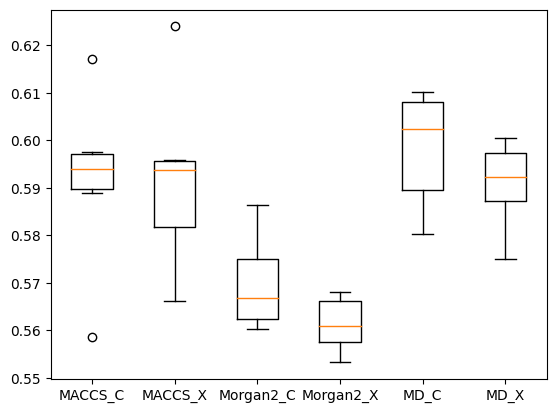

In [39]:
plt.figuresize=(16,16)
label=['MACCS_C','MACCS_X','Morgan2_C','Morgan2_X','MD_C','MD_X']
plt.boxplot([scores_df.C_MACCS, scores_df.X_MACCS,scores_df.C_Morgan2,scores_df.X_Morgan2,scores_df.C_MD,scores_df.X_MD], labels=label)
plt.show()

In [40]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp

# Perform the Friedman test and Nemenyi post-hoc test for each dataset separately
friedman_test = stats.friedmanchisquare(scores_df['C_MACCS'], scores_df['X_MACCS'],scores_df['C_Morgan2'],scores_df['X_Morgan2'],scores_df['C_MD'],scores_df['X_MD'])
print(f"Friedman test statistic: {friedman_test.statistic}")
print(f"Friedman test p-value: {friedman_test.pvalue}")

# If p-value < 0.05, we can reject the null hypothesis and proceed with the post-hoc test
if friedman_test.pvalue < 0.05:
        # Nemenyi post hoc test
    posthoc1 = sp.posthoc_nemenyi_friedman(scores_df)
    print("\nNemenyi Post-hoc Test:")
    print(posthoc1)

Friedman test statistic: 20.47619047619048
Friedman test p-value: 0.0010169716303787297

Nemenyi Post-hoc Test:
            C_MACCS   X_MACCS  C_Morgan2  X_Morgan2      C_MD      X_MD
C_MACCS    1.000000  0.900000   0.338882   0.091488  0.796011  0.900000
X_MACCS    0.900000  1.000000   0.338882   0.091488  0.796011  0.900000
C_Morgan2  0.338882  0.338882   1.000000   0.900000  0.015147  0.528649
X_Morgan2  0.091488  0.091488   0.900000   1.000000  0.001598  0.187873
C_MD       0.796011  0.796011   0.015147   0.001598  1.000000  0.617769
X_MD       0.900000  0.900000   0.528649   0.187873  0.617769  1.000000


In [42]:
posthoc1

,C_MACCS,X_MACCS,C_Morgan2,X_Morgan2,C_MD,X_MD
C_MACCS,1.000000,0.900000,0.338882,0.091488,0.796011,0.900000
X_MACCS,0.900000,1.000000,0.338882,0.091488,0.796011,0.900000
C_Morgan2,0.338882,0.338882,1.000000,0.900000,0.015147,0.528649
X_Morgan2,0.091488,0.091488,0.900000,1.000000,0.001598,0.187873
C_MD,0.796011,0.796011,0.015147,0.001598,1.000000,0.617769
X_MD,0.900000,0.900000,0.528649,0.187873,0.617769,1.000000


<Axes: >

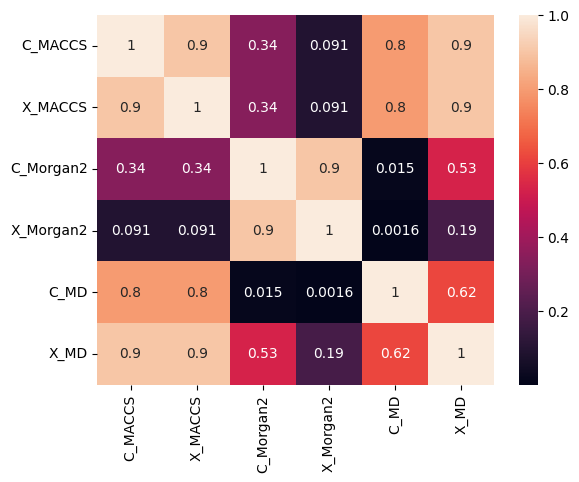

In [43]:
sn.heatmap(posthoc1,annot=True)

In [47]:
friedman_test = stats.friedmanchisquare(scores_df['UNX_MACCS'],scores_df['X_MACCS'],scores_df['X_Morgan2'],scores_df['X_MD'])
print(f"Friedman test statistic: {friedman_test.statistic}")
print(f"Friedman test p-value: {friedman_test.pvalue}")

# If p-value < 0.05, we can reject the null hypothesis and proceed with the post-hoc test
if friedman_test.pvalue < 0.05:
        # Nemenyi post hoc test
    posthoc2 = sp.posthoc_nemenyi_friedman(df2)
    print("\nNemenyi Post-hoc Test:")
    print(posthoc2)

Friedman test statistic: 15.200000000000003
Friedman test p-value: 0.0016534710516881628

Nemenyi Post-hoc Test:
           UNX_MACCS   X_MACCS  X_Morgan2      X_MD
UNX_MACCS   1.000000  0.009454   0.783106  0.009454
X_MACCS     0.009454  1.000000   0.113705  0.900000
X_Morgan2   0.783106  0.113705   1.000000  0.113705
X_MD        0.009454  0.900000   0.113705  1.000000


In [28]:
import matplotlib.pyplot as plt

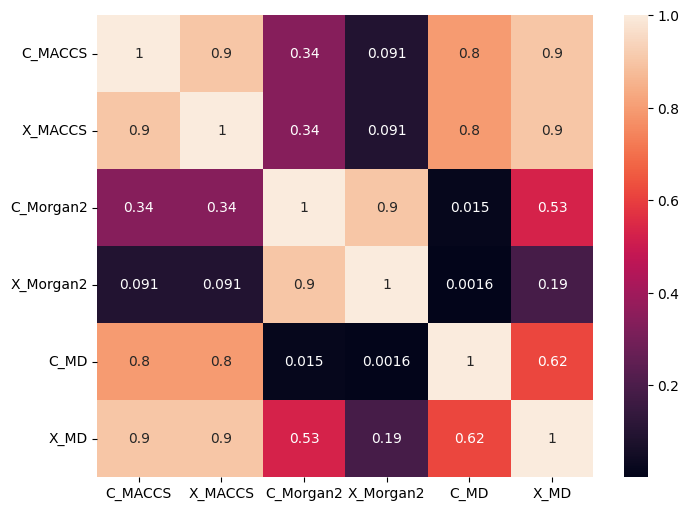

In [44]:
plt.figure(figsize=(8,6))
sn.heatmap(posthoc1,annot=True)
plt.savefig("heatmap.png", dpi=600, bbox_inches='tight')

<Axes: >

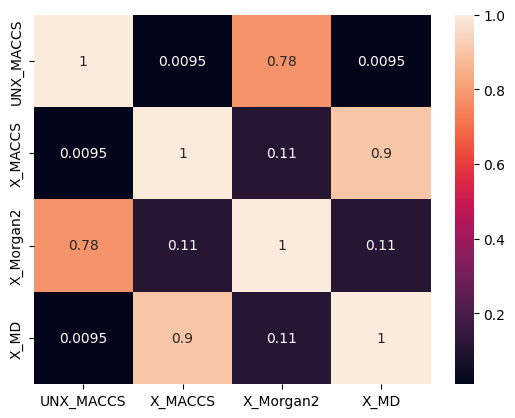

In [48]:
sn.heatmap(posthoc2,annot=True)